# CNN-VAE on HUTUBS dataset (alt repr)

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display

from utils_data import load_hutubs_hrtf_alt
from utils_model import create_model_fconv
from utils_train import train_model
from utils_plot import plot_latent_space, plot_latent_pairs, plot_reconstructions, plot_reconstruction_hrtfs, plot_xcorr

## Load data

In [4]:
# show all possible azimuths
sio.loadmat('./data/hutubs_hrtf/configs.mat')['azimuths'][0]

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355], dtype=uint16)

In [56]:
# load HRTFs from HUTUBS 
filters = {
    'ears': ['left'],
    #'ids': range(1,15),
    'azimuths': [75,80,85,90,95,100,105]
}
(x_train, y_train), (x_test, y_test) = load_hutubs_hrtf_alt(
    dataset_path='./data/hutubs_hrtf/', 
    anthropometrics_path='./data/hutubs_measures.csv', 
    data_content='hrtfs',
    user_filters=filters)

image_size = x_train.shape[1:3]
x_train = np.reshape(x_train, [-1, *image_size, 1])
x_test = np.reshape(x_test, [-1, *image_size, 1])
# adjust shape to be power of 2
x_train = x_train[:, :32]
x_test = x_test[:, :32]
image_size = x_train.shape[1:3]
# show resulting data shapes
print('train set:', x_train.shape)
print('test set: ', x_test.shape)

100%|██████████| 56/56 [00:00<00:00, 458.61it/s]

Train/test split: 10/4 ids
train set: (40, 32, 128, 1)
test set:  (16, 32, 128, 1)


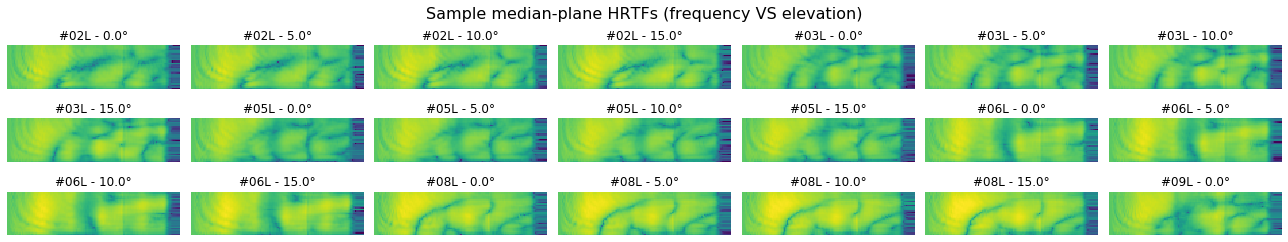

In [57]:
nr, nc = 3, 7
w = 18
h = w / 5
fig, ax = plt.subplots(nr, nc, figsize=(w, h))
for i, a in enumerate(ax.flatten()):
    n = int(float(len(x_train) / len(ax.flatten()) * i))
    im = a.imshow(x_train[i,:,:,0], vmin=-60, vmax=20)
    #a.set_title(str(n))
    a.set_title('#{:02}{} - {}°'.format(
        y_train['id'].iloc[i], 
        y_train['ear'].iloc[i][0].upper(),
        y_train['azimuth'].iloc[i]))
    #a.imshow(x_train[i,...,0])
    a.axis('off')
    #plt.colorbar(im, ax=a)
fig.suptitle('Sample median-plane HRTFs (frequency VS elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])

## Create network

In [41]:
# network parameters
modelname = 'fconv'
input_shape = (*image_size, 1)
filters_layers = [256, 128, 64][::-1]
kernel_size = 3
n_latent = 16
use_batchnorm = True
use_maxpool = True
freq_loss = False

# create 3d-conv net
encoder, decoder, vae = create_model_fconv(
    input_shape=input_shape, filters_layers=filters_layers, 
    kernel_size=kernel_size,n_latent=n_latent, 
    use_batchnorm=use_batchnorm,use_maxpool=use_maxpool, 
    gen_plots=False, freq_loss=freq_loss)

# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'

# store logs
logs_df = pd.read_pickle('./logs_hrtf_alt.pkl')
logs_df.loc[log_id] = {
    'modelname': modelname,
    'input_shape': input_shape,
    'filters_layers': filters_layers,
    'kernel_size': kernel_size,
    'n_latent': n_latent,
    'use_batchnorm': use_batchnorm,
    'use_maxpool': use_maxpool,
    'freq_loss': freq_loss,
    'date_time': datetime.datetime.now()
}
logs_df.to_pickle('./logs_hrtf_alt.pkl')
display(logs_df)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 128, 1)   0                                            
__________________________________________________________________________________________________
encoder_0_conv (Conv2D)         (None, 32, 128, 64)  640         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_0_bnorm (BatchNormaliza (None, 32, 128, 64)  256         encoder_0_conv[0][0]             
__________________________________________________________________________________________________
encoder_0_act (Activation)      (None, 32, 128, 64)  0           encoder_0_bnorm[0][0]            
__________________________________________________________________________________________________
encoder_0_

,modelname,input_shape,filters_layers,kernel_size,n_latent,use_batchnorm,use_maxpool,freq_loss,date_time
log_id,,,,,,,,,
71918091,fconv,"(36, 128, 1)","[128, 256]",3,16,True,True,False,2019-10-24 13:54:36.624143
71918100,fconv,"(36, 128, 1)","[128, 256]",3,16,True,True,False,2019-10-24 13:54:45.326627
71918160,fconv,"(36, 128, 1)","[128, 256]",3,16,True,True,False,2019-10-24 13:55:45.829486
71918184,fconv,"(36, 128, 1)","[64, 128]",3,16,True,True,False,2019-10-24 13:56:09.792442
71919808,fconv,"(36, 128, 1)","[64, 128]",3,16,True,True,False,2019-10-24 14:23:13.013286
71919896,fconv,"(36, 128, 1)","[64, 128]",3,16,True,True,False,2019-10-24 14:24:41.857493
71920155,fconv,"(36, 128, 1)","[64, 128]",3,16,False,False,False,2019-10-24 14:29:00.467989
71975482,fconv,"(32, 128, 1)","[32, 64, 128]",3,16,False,False,False,2019-10-25 05:51:07.180959
71975726,fconv,"(32, 128, 1)","[32, 64, 128]",3,16,False,False,False,2019-10-25 05:55:11.957715


## Train network

In [42]:
# training parameters
batch_size = x_train.shape[0] // 16
print(batch_size)
epochs = 200
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
label_train = None
label_test = None
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')
trainig_history = train_model(vae, x_train, label_train, 
                              x_test, label_test, 
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

324
Training log: ./logs/71991969
Training from 0 to 200..


loss: 25.32: 100%|██████████| 200/200 [14:57<00:00,  4.49s/it]


## Plot results

minimum loss:  25.32220423221588


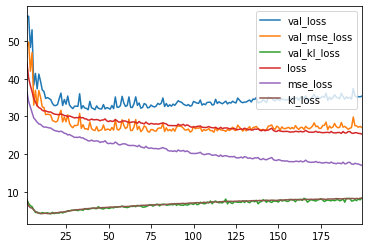

In [52]:
trainig_history.iloc[2:].plot()
print('minimum loss: ', trainig_history['loss'].min())

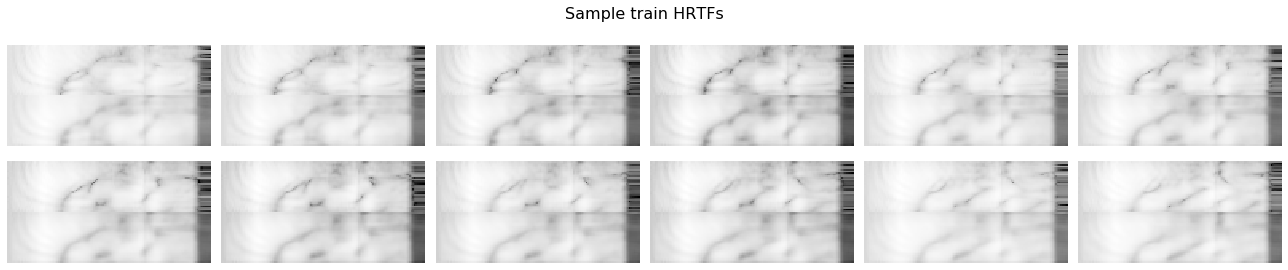

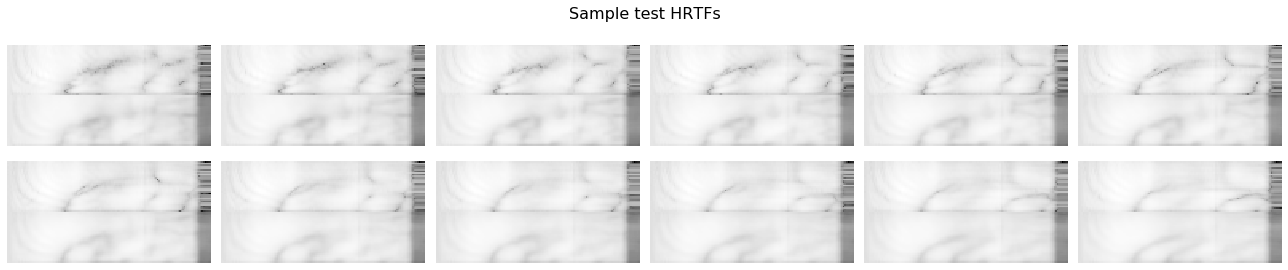

In [53]:
# take data
data_train = (x_train, None)
data_test = (x_test, None)

# plot reconstructions
fig, axs = plt.subplots(2, 6, figsize=(18, 4))
plot_reconstructions(encoder, decoder, data_train, 
                     axs=axs, batch_size=batch_size, freq_loss=freq_loss, side='v')
fig.suptitle('Sample train HRTFs', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])

# plot reconstructions
fig, axs = plt.subplots(2, 6, figsize=(18, 4))
plot_reconstructions(encoder, decoder, data_test, 
                     axs=axs, batch_size=batch_size, freq_loss=freq_loss, side='v')
fig.suptitle('Sample test HRTFs', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])

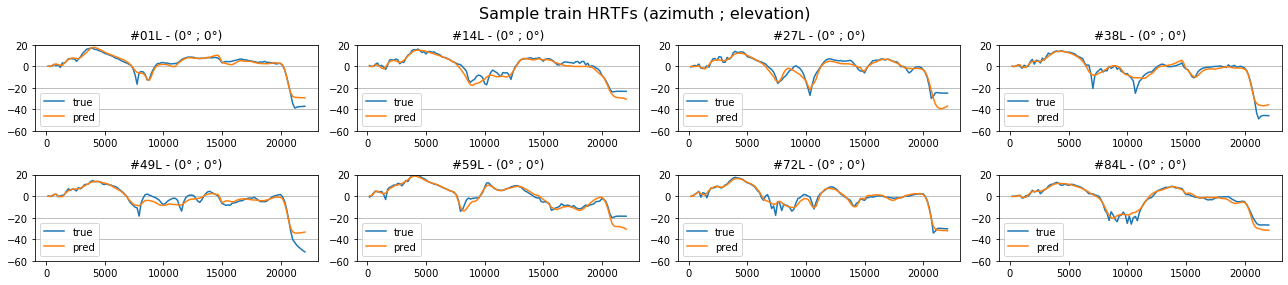

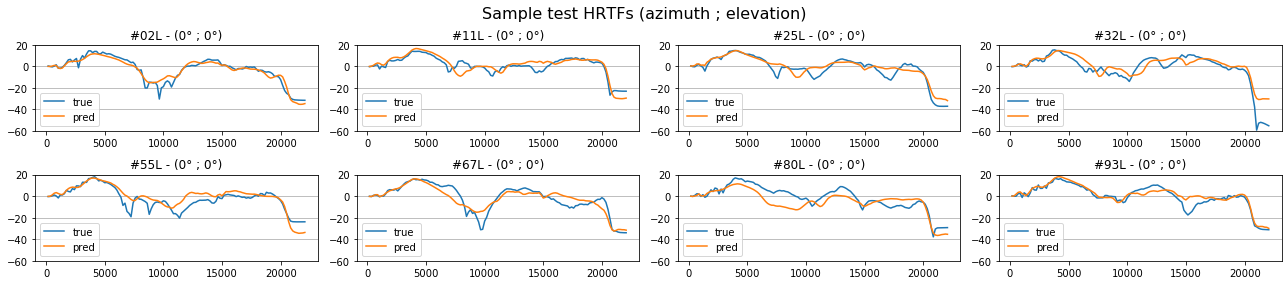

In [54]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# hrtf reconstructions
fig, axs = plt.subplots(2, 4, figsize=(18, 4))
plot_reconstruction_hrtfs(encoder, decoder, data_train, 
                          axs=axs, batch_size=batch_size, elevation=0)
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])

# hrtf reconstructions
fig, axs = plt.subplots(2, 4, figsize=(18, 4))
plot_reconstruction_hrtfs(encoder, decoder, data_test, 
                          axs=axs, batch_size=batch_size, elevation=0)
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])

In [1]:
# data to use
drop_cols = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, y_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, y_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
plot_xcorr(encoder, data_train, ax,
           batch_size=batch_size, pca=False,
           labels=True)

NameError: name 'y_train' is not defined

In [ ]:
# TODO:
# - 3d plots
# - hyperparam opt: `talos`
# - noise solo a input
# - train con 'cubo' (elevation, azimuth, frequency) https://www.sciencedirect.com/science/article/pii/S0925231215014940
# - semisupervised learning http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
# - inception layers (unabridged) https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b
# - plot: tsne on latent space
# - extract hrtf/hrir
# - plot: hrtf/hrir
# - freq_loss: pearson vs mse?
# - store and load trained model

In [76]:
## NOTE: only run if there's no existing log file!
logs_df = pd.DataFrame(columns=[
    'modelname', 'input_shape', 'filters_layers', 
    'kernel_size', 'n_latent', 'use_batchnorm', 
    'use_maxpool', 'freq_loss', 'date_time'])
logs_df.index.name = 'log_id'
logs_df.to_pickle('./logs_hrtf_alt.pkl')



In [50]:
pd.DataFrame({'X': ['aa', 'bb', 'cc', 'cc']})['X'].factorize()[0]

array([0, 1, 2, 2])